In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

from lib.data.datareader_total import DataReaderTotal
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_fit3d import DataReaderFIT3D
from lib.utils.args import get_opts_args
from lib.model.load_model import load_model
from lib.model.load_dataset import load_dataset
from lib.data.dataset_motion_3d import MotionDataset3DTotal
from lib.model.evaluation import *

In [9]:
dataset_name = '3dhp'
overwrite_list = []
source_list                                   = load_data(dataset_name=dataset_name, data_type='source_list', overwrite_list=overwrite_list)
cam_params                                    = load_data(dataset_name=dataset_name, data_type='cam_param', overwrite_list=overwrite_list)
cam_params_adaptive_focal                     = load_data(dataset_name=dataset_name, data_type='cam_param', adaptive_focal=True, overwrite_list=overwrite_list)
world_3ds                                     = load_data(dataset_name=dataset_name, data_type='world_3d', overwrite_list=overwrite_list)
cam_3ds                                       = load_data(dataset_name=dataset_name, data_type='cam_3d', overwrite_list=overwrite_list)
img_2ds                                       = load_data(dataset_name=dataset_name, data_type='img_2d', overwrite_list=overwrite_list)
img_3ds                                       = load_data(dataset_name=dataset_name, data_type='img_3d', overwrite_list=overwrite_list)
scale_factors                                 = load_data(dataset_name=dataset_name, data_type='scale_factor', overwrite_list=overwrite_list)
img_25ds                                      = load_data(dataset_name=dataset_name, data_type='img_25d', overwrite_list=overwrite_list)
cam_3d_canonicals_same_z                      = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
cam_3d_canonicals_same_dist                   = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
cam_3d_canonicals_fixed_dist_5                = load_data(dataset_name=dataset_name, data_type='cam_3d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)
img_2d_canonicals_same_z                      = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_z', overwrite_list=overwrite_list)
img_2d_canonicals_same_dist                   = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='same_dist', overwrite_list=overwrite_list)
img_2d_canonicals_fixed_dist_5                = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='fixed_dist_5', overwrite_list=overwrite_list)
img_2d_canonicals_fixed_dist_5_adaptive_focal = load_data(dataset_name=dataset_name, data_type='img_2d_canonical', canonical_type='fixed_dist_5', adaptive_focal=True, overwrite_list=overwrite_list)

[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_param_adaptive_focal...
[overwrite: False] ==> Loading 3DHP world_3d...
[overwrite: False] ==> Loading 3DHP cam_3d...
[overwrite: False] ==> Loading 3DHP img_2d...
[overwrite: False] ==> Loading 3DHP img_3d...
[overwrite: False] ==> Loading 3DHP scale_factor...
[overwrite: False] ==> Loading 3DHP img_25d...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_same_z...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_same_dist...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_fixed_dist_5...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_same_z...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_same_dist...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_fixed_dist_5...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_fixed_dist_5_adaptive_focal...


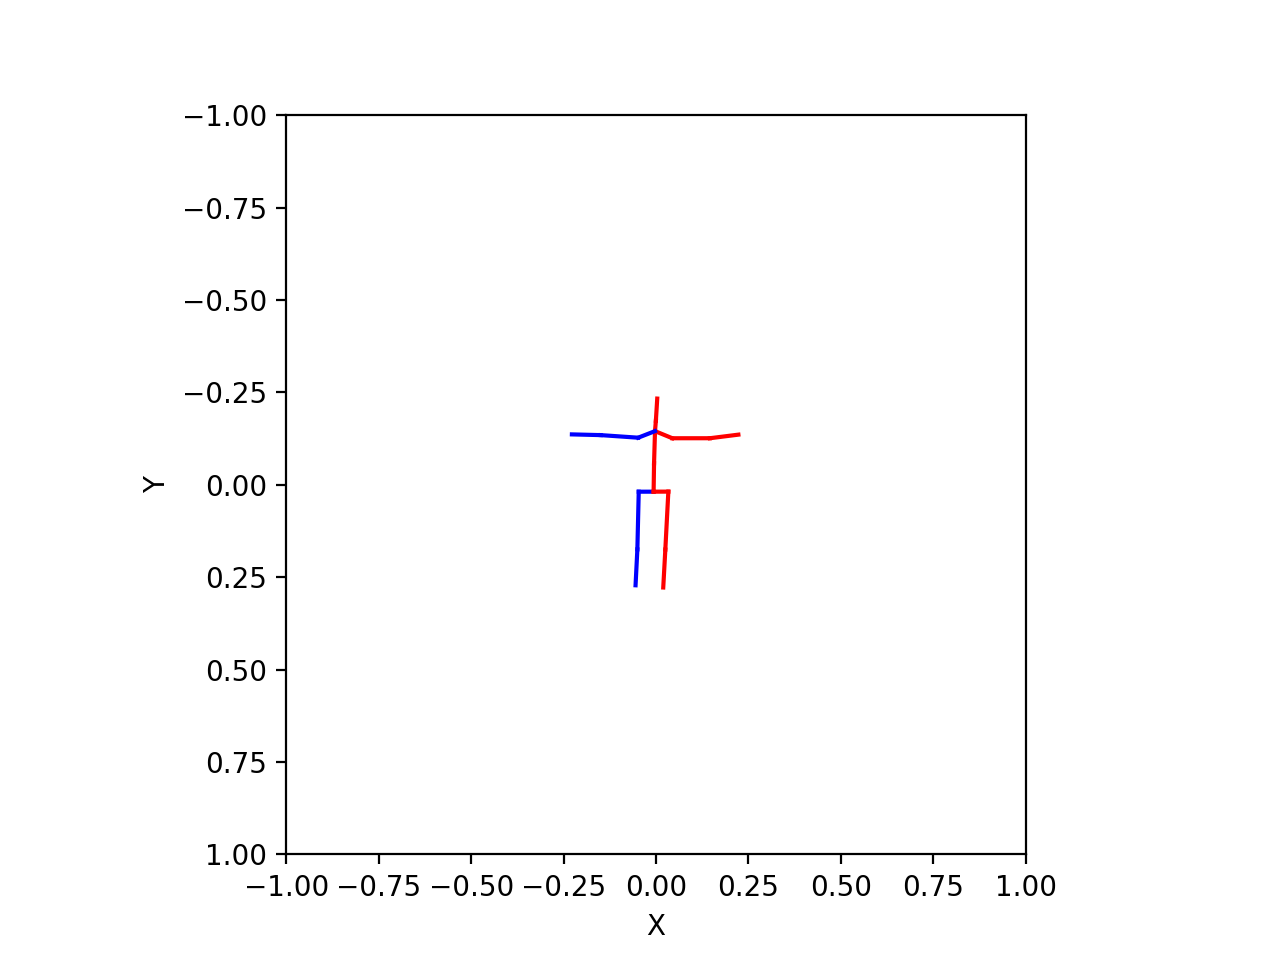

In [11]:
source = 'TS1_None_None'
subject, cam_id, action = split_source_name(source, dataset_name)
cam_param = cam_params[subject][action][cam_id]
W, H, R, t, C, intrinsic, extrinsic = cam_param['W'], cam_param['H'], cam_param['R'], cam_param['t'], cam_param['C'], cam_param['intrinsic'], cam_param['extrinsic']
fx, fy, cx, cy = intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2]

frame_num = 0
img_2d_canonical_fixed_dist_5 = img_2d_canonicals_fixed_dist_5[subject][action][cam_id]
img_2d_canonical_fixed_dist_5_norm = normalize_input(img_2d_canonical_fixed_dist_5, W, H)

fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig)
draw_2d_pose(ax, img_2d_canonical_fixed_dist_5_norm[frame_num], normalize=True)
plt.show()

In [12]:
data_type = 'img_2d_canonicals_fixed_dist_5_adaptive_focal'
save_folder = f'/home/{user}/codes/MotionBERT/videos/{dataset_name}/{data_type}'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [13]:
random.shuffle(source_list)
target_list = source_list[:20]
target_list

['S5_cam4_Seq1',
 'S8_cam7_Seq1',
 'S2_cam0_Seq2',
 'S4_cam7_Seq1',
 'S4_cam3_Seq1',
 'S3_cam11_Seq1',
 'S7_cam13_Seq2',
 'S3_cam7_Seq1',
 'S8_cam13_Seq2',
 'S1_cam3_Seq1',
 'S7_cam2_Seq2',
 'S8_cam4_Seq2',
 'S7_cam8_Seq1',
 'S1_cam4_Seq2',
 'S7_cam5_Seq2',
 'S2_cam9_Seq2',
 'S2_cam13_Seq1',
 'S5_cam3_Seq2',
 'S6_cam8_Seq1',
 'S8_cam2_Seq2']

In [15]:
target_list = [source for source in source_list if 'TS' in source]
target_list

['TS4_None_None',
 'TS6_None_None',
 'TS2_None_None',
 'TS1_None_None',
 'TS5_None_None',
 'TS3_None_None']

In [16]:
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig)

for source in target_list:
    #if 'TS' not in source: continue
    subject, cam_id, action = split_source_name(source, dataset_name)
    save_path = os.path.join(save_folder, f'{subject}_{cam_id}_{action}.mp4')
    if os.path.exists(save_path): continue
    
    cam_param = cam_params[subject][action][cam_id]
    W, H, R, t, C, intrinsic, extrinsic = cam_param['W'], cam_param['H'], cam_param['R'], cam_param['t'], cam_param['C'], cam_param['intrinsic'], cam_param['extrinsic']
    fx, fy, cx, cy = intrinsic[0][0], intrinsic[1][1], intrinsic[0][2], intrinsic[1][2]

    img_2d_canonical_fixed_dist_5_adaptive_focal = img_2d_canonicals_fixed_dist_5_adaptive_focal[subject][action][cam_id]
    img_2d_canonical_fixed_dist_5_adaptive_focal_norm = normalize_input(img_2d_canonical_fixed_dist_5_adaptive_focal, W, H)
    
    
    videowriter = imageio.get_writer(save_path, fps=6)
    for frame_num in tqdm(range(0, len(img_2d_canonical_fixed_dist_5_adaptive_focal_norm), 5)):
        clear_axes(ax)
        draw_2d_pose(ax, img_2d_canonical_fixed_dist_5_adaptive_focal_norm[frame_num], normalize=True)
        
        canvas = FigureCanvas(fig)
        canvas.draw()
        image_from_plot = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
        image_from_plot = image_from_plot.reshape(canvas.get_width_height()[::-1] + (3,))
        videowriter.append_data(image_from_plot)
    videowriter.close()

  0%|          | 0/1109 [00:00<?, ?it/s]

/tmp/ipykernel_580709/1111171824.py:26: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
100%|██████████| 1014/1014 [00:30<00:00, 33.55it/s]
